In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb
sns.set_style('whitegrid')

In [55]:
def metrics(train_preds, y_train, test_preds, y_test):
    
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")

    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

## EDA

In [3]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
grouped = df.groupby('Rating')['Rating'].count()
grouped

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating'>

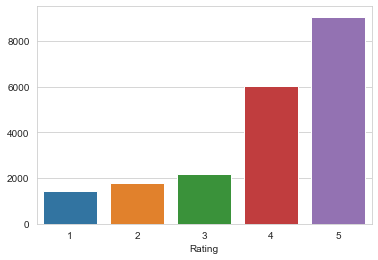

In [5]:
sns.barplot(x = grouped.index, y = grouped.values)

In [6]:
df['words'] = [x.split() for x in df['Review']]

df['word_count'] = [len(x) for x in df['words']]

In [7]:
df.head()

,Review,Rating,words,word_count
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191


In [8]:
grouped_rating = df.groupby('Rating')['word_count'].mean()
grouped_rating

Rating
1    112.365236
2    126.601227
3    114.705586
4    107.771651
5     93.963773
Name: word_count, dtype: float64

<AxesSubplot:xlabel='Rating'>

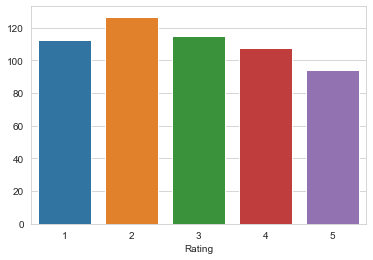

In [9]:
sns.barplot(x = grouped_rating.index, y = grouped_rating.values)

## Preprocessing

In [10]:
sw = stopwords.words('english')

In [11]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [13]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [14]:
df.head()

,Review,Rating,words,word_count,tokenized
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...


In [15]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'
    

In [16]:
df['new_rating'] = df['Rating'].apply(new_rating)

In [17]:
df.head()

,Review,Rating,words,word_count,tokenized,new_rating
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...,average
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...,poor
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room experience hotel monaco seattle good...,average
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...,excellent
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...,excellent


In [18]:
df['tokenized_words'] = [x.split() for x in df['tokenized']]

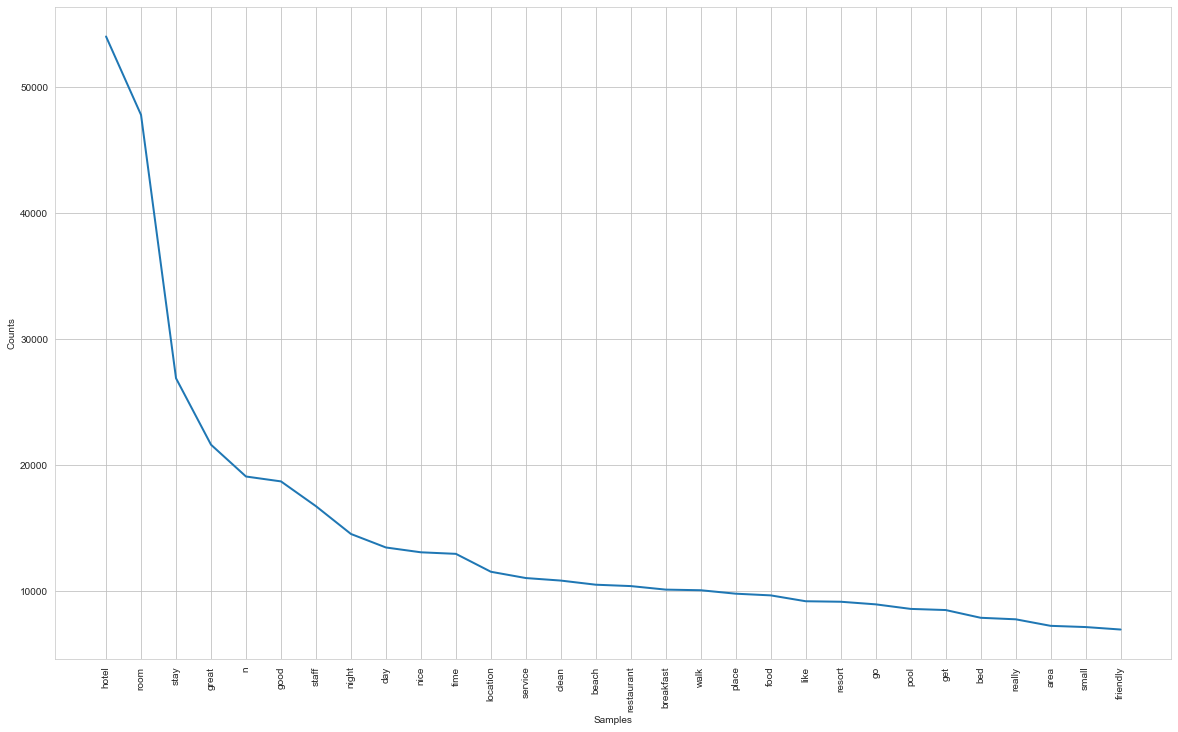

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
tokenized_words = df['tokenized_words'].to_list()
word_list = []
for x in tokenized_words:
    word_list.extend(x)
word_list
freq_dist_text = nltk.FreqDist(word_list)
plt.subplots(figsize=(20,12))
freq_dist_text.plot(30)

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


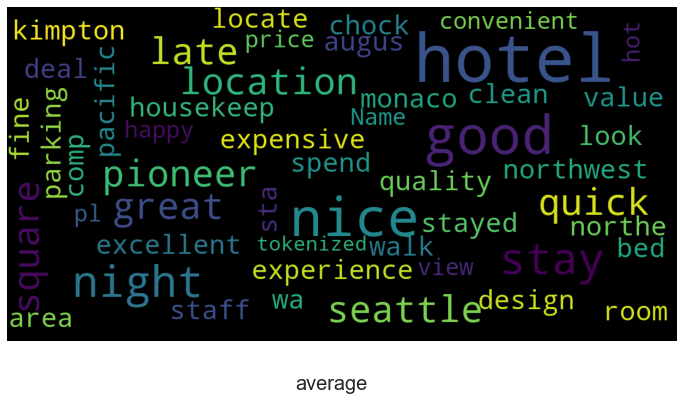

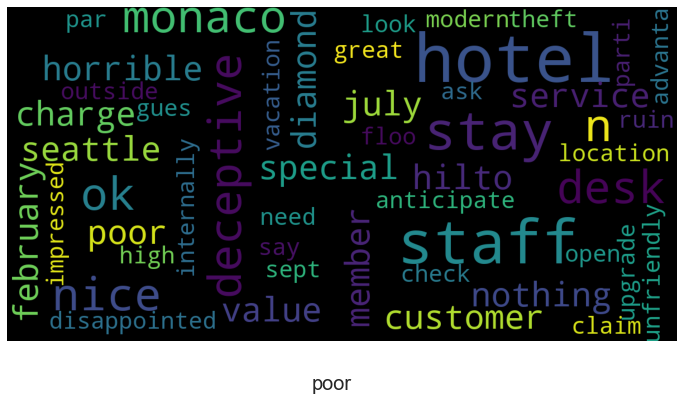

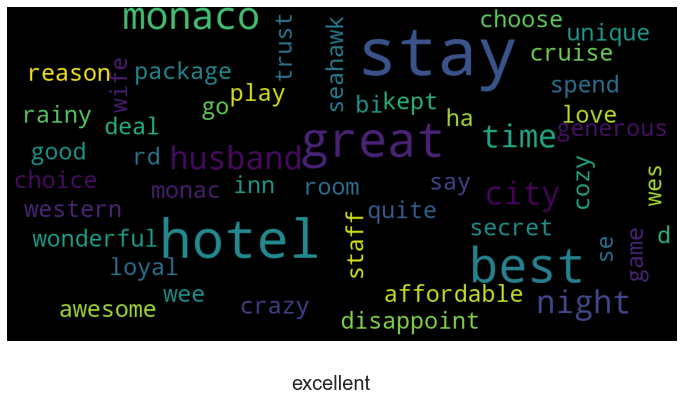

In [23]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

In [19]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 5
# for Genre, category_id in sorted(category_to_id.items()):
#     print(Genre, category_id)
#     features_chi2 = chi2(train_features, y_train == Genre)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf_train.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Genre))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [20]:
from sklearn.model_selection import train_test_split

In [24]:
X = df['tokenized']
y = df['new_rating']

In [25]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

### ASK SEAN do you train test split on the original data or the tokenized data?
* deal with class imbalance in NLP, SMOTE/Tomek Links?

In [27]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.9, min_df=.10,  ngram_range=(1,1))

In [28]:
train_features = tfidf_train.fit_transform(X_train).toarray()

In [29]:
test_features = tfidf_train.transform(X_test).toarray()

## PCA

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, random_state=1)
pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [31]:
sum(pca.explained_variance_ratio_)

0.9008503033304058

In [32]:
pca.n_components_

106

In [33]:
pca_train

array([[-0.12982976, -0.00419907, -0.06882767, ..., -0.03306649,
        -0.0076321 ,  0.0807271 ],
       [ 0.07294761, -0.17393382,  0.00253424, ...,  0.0659986 ,
         0.07183434,  0.03395064],
       [-0.01000119,  0.04699181, -0.20443509, ...,  0.0287658 ,
        -0.01301004,  0.05728114],
       ...,
       [ 0.012341  , -0.02909238,  0.22655422, ..., -0.02182811,
         0.05265633,  0.09155197],
       [-0.09972244,  0.23104883,  0.03865806, ...,  0.13054261,
         0.04680501, -0.01377727],
       [ 0.14932522,  0.11619422, -0.01700038, ..., -0.057612  ,
         0.00508655, -0.03903406]])

## Naive Bayes

In [35]:
scorer = make_scorer(f1_score, average = 'weighted')

In [36]:
nb = MultinomialNB()

In [37]:
params=  {'alpha': [0.09, 0.1,0.11]}

In [38]:
# Instantiate the grid search model
grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [39]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.9s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [40]:
print(grid_search_nb.best_params_,
      grid_search_nb.best_score_)

{'alpha': 0.09} 0.596915223219809


In [41]:
preds_nb = grid_search_nb.best_estimator_.predict(test_features)

In [42]:
preds_nb_train = grid_search_nb.best_estimator_.predict(train_features)

In [43]:
print(classification_report(y_train,preds_nb_train))

              precision    recall  f1-score   support

     average       0.56      0.59      0.58      6539
   excellent       0.65      0.78      0.71      7264
        poor       0.86      0.23      0.37      2589

    accuracy                           0.62     16392
   macro avg       0.69      0.54      0.55     16392
weighted avg       0.65      0.62      0.60     16392



In [44]:
# Print a classification report
print(classification_report(y_test,preds_nb))

              precision    recall  f1-score   support

     average       0.58      0.58      0.58      1684
   excellent       0.64      0.81      0.71      1790
        poor       0.85      0.21      0.34       625

    accuracy                           0.62      4099
   macro avg       0.69      0.53      0.54      4099
weighted avg       0.65      0.62      0.60      4099



## Logistic Regression

In [45]:
from sklearn import linear_model

In [46]:
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)

# Create hyperparameter options
hyperparameters = dict(C=C)

In [47]:
# Create logistic regression
logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced')

In [48]:
# Instantiate the grid search model
grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = hyperparameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [49]:
grid_search_LR.fit(train_features, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.1s finished


GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [50]:
print(grid_search_LR.best_params_,
      grid_search_LR.best_score_)

{'C': 1.0} 0.6443912765340435


In [51]:
preds_LR_train = grid_search_LR.best_estimator_.predict(train_features)

In [52]:
print(classification_report(y_train,preds_LR_train))

              precision    recall  f1-score   support

     average       0.63      0.57      0.60      6539
   excellent       0.72      0.68      0.70      7264
        poor       0.57      0.82      0.67      2589

    accuracy                           0.66     16392
   macro avg       0.64      0.69      0.66     16392
weighted avg       0.66      0.66      0.66     16392



In [53]:
preds_LR_test = grid_search_LR.best_estimator_.predict(test_features)

In [54]:
print(classification_report(y_test,preds_LR_test))

              precision    recall  f1-score   support

     average       0.65      0.54      0.59      1684
   excellent       0.72      0.71      0.71      1790
        poor       0.55      0.81      0.65       625

    accuracy                           0.66      4099
   macro avg       0.64      0.69      0.65      4099
weighted avg       0.66      0.66      0.65      4099



## Decision Tree

In [63]:
from sklearn import tree 

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

In [59]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(criterion=criterion,
                max_depth=max_depth)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=parameters, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)


In [64]:
DT.fit(train_features, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [65]:
DT_test_preds = DT.predict(test_features)
DT_train_preds = DT.predict(train_features)

metrics(DT_train_preds, y_train, DT_test_preds, y_test)

Training Accuracy:	0.6689 	Testing Accuracy:	0.5689
Training Precision:	0.6787 	Testing Precision:	0.5751
Training Recall:	0.6689 	Testing Recall:		0.5689
Training F1:		0.6698 	Testing F1:		0.5703


In [76]:
print(grid_search_DT.best_params_,
      grid_search_DT.best_score_)

{'criterion': 'gini', 'max_depth': 10} 0.44983075213774015


In [57]:
preds_DT_train = grid_search_DT.best_estimator_.predict(train_features)

NameError: name 'grid_search_DT' is not defined

In [78]:
print(metrics.classification_report(y_train,preds_DT_train))

              precision    recall  f1-score   support

           1       0.65      0.42      0.51      1129
           2       0.45      0.30      0.36      1460
           3       0.60      0.22      0.32      1752
           4       0.51      0.47      0.49      4787
           5       0.62      0.82      0.71      7264

    accuracy                           0.58     16392
   macro avg       0.57      0.45      0.48     16392
weighted avg       0.57      0.58      0.56     16392



In [79]:
preds_DT_test = grid_search_DT.best_estimator_.predict(test_features)

In [80]:
print(metrics.classification_report(y_test,preds_DT_test))

              precision    recall  f1-score   support

           1       0.51      0.29      0.37       292
           2       0.24      0.16      0.19       333
           3       0.32      0.10      0.15       432
           4       0.42      0.36      0.39      1252
           5       0.57      0.79      0.67      1790

    accuracy                           0.50      4099
   macro avg       0.41      0.34      0.35      4099
weighted avg       0.47      0.50      0.47      4099



## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

rf.fit(train_features, y_train)

rf_test_preds = rf.predict(test_features)
rf_train_preds = rf.predict(train_features)

metrics(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	1.0 	Testing Accuracy:	0.6363
Training Precision:	1.0 	Testing Precision:	0.6433
Training Recall:	1.0 	Testing Recall:		0.6363
Training F1:		1.0 	Testing F1:		0.6319


## PCA Grid Searching

### NB

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(pca_train)
test_features_scaled = scaler.transform(pca_test)

In [67]:
grid_search_nb_pca = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_nb_pca.fit(train_features_scaled, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.3s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [68]:
grid_search_nb_pca.best_estimator_

MultinomialNB(alpha=0.09)

In [69]:
preds_NB_train_pca = grid_search_nb_pca.best_estimator_.predict(train_features_scaled)

In [71]:
print(classification_report(y_train,preds_NB_train_pca))

/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     average       0.90      0.00      0.01      6539
   excellent       0.44      1.00      0.61      7264
        poor       0.00      0.00      0.00      2589

    accuracy                           0.44     16392
   macro avg       0.45      0.33      0.21     16392
weighted avg       0.56      0.44      0.27     16392



In [72]:
preds_NB_test_pca = grid_search_nb_pca.best_estimator_.predict(test_features_scaled)

In [73]:
print(classification_report(y_test,preds_NB_test_pca))

              precision    recall  f1-score   support

     average       0.80      0.00      0.00      1684
   excellent       0.44      1.00      0.61      1790
        poor       0.00      0.00      0.00       625

    accuracy                           0.44      4099
   macro avg       0.41      0.33      0.20      4099
weighted avg       0.52      0.44      0.27      4099



/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LR

In [74]:
grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = hyperparameters, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_LR.fit(pca_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.2s finished


GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [75]:
grid_search_LR.best_estimator_

LogisticRegression(C=3.5938136638046276, class_weight='balanced')

In [76]:
preds_LR_train_pca = grid_search_LR.best_estimator_.predict(pca_train)

In [78]:
print(classification_report(y_train,preds_LR_train_pca))

              precision    recall  f1-score   support

     average       0.63      0.56      0.59      6539
   excellent       0.72      0.67      0.70      7264
        poor       0.56      0.82      0.66      2589

    accuracy                           0.65     16392
   macro avg       0.64      0.68      0.65     16392
weighted avg       0.66      0.65      0.65     16392



In [79]:
preds_LR_test_pca = grid_search_LR.best_estimator_.predict(pca_test)

In [80]:
print(classification_report(y_test,preds_LR_test_pca))

              precision    recall  f1-score   support

     average       0.65      0.55      0.60      1684
   excellent       0.72      0.71      0.71      1790
        poor       0.54      0.80      0.65       625

    accuracy                           0.66      4099
   macro avg       0.64      0.68      0.65      4099
weighted avg       0.66      0.66      0.66      4099



### DT

In [81]:
grid_search_DT = GridSearchCV(estimator=DT, param_grid=parameters, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [82]:
grid_search_DT.best_estimator_

DecisionTreeClassifier(max_depth=6, random_state=42)

In [83]:
preds_DT_train_pca = grid_search_DT.best_estimator_.predict(pca_train)

In [84]:
print(classification_report(y_train,preds_DT_train_pca))

              precision    recall  f1-score   support

     average       0.61      0.53      0.57      6539
   excellent       0.65      0.73      0.69      7264
        poor       0.58      0.60      0.59      2589

    accuracy                           0.63     16392
   macro avg       0.61      0.62      0.61     16392
weighted avg       0.63      0.63      0.62     16392



In [85]:
preds_DT_test_pca = grid_search_DT.best_estimator_.predict(pca_test)

In [86]:
print(classification_report(y_test,preds_DT_test_pca))

              precision    recall  f1-score   support

     average       0.59      0.48      0.53      1684
   excellent       0.60      0.71      0.65      1790
        poor       0.54      0.54      0.54       625

    accuracy                           0.59      4099
   macro avg       0.58      0.57      0.57      4099
weighted avg       0.59      0.59      0.58      4099



### RF

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


In [87]:
# grid_search_RF = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)

# grid_search_RF.fit(pca_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 120.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 317.9min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [117]:
grid_search_RF.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [107]:
preds_RF_train_pca = grid_search_RF.best_estimator_.predict(pca_train)

In [108]:
print(metrics.classification_report(y_train,preds_RF_train_pca))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1129
           2       0.00      0.00      0.00      1460
           3       0.00      0.00      0.00      1752
           4       1.00      0.03      0.06      4787
           5       0.45      1.00      0.62      7264

    accuracy                           0.45     16392
   macro avg       0.29      0.21      0.14     16392
weighted avg       0.49      0.45      0.29     16392



/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
preds_RF_test_pca = grid_search_RF.best_estimator_.predict(pca_test)

In [214]:
print(metrics.classification_report(y_test,preds_RF_test_pca))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       292
           2       0.00      0.00      0.00       333
           3       0.00      0.00      0.00       432
           4       0.00      0.00      0.00      1252
           5       0.44      1.00      0.61      1790

    accuracy                           0.44      4099
   macro avg       0.09      0.20      0.12      4099
weighted avg       0.19      0.44      0.27      4099



/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost - Non GS

In [87]:
grad_boost_class = xgboost.XGBClassifier(random_state=42, objective='binary:logistic')

grad_boost_class.fit(train_features, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
preds_XG_train_pca = grad_boost_class.predict(train_features)

In [90]:
print(classification_report(y_train,preds_XG_train_pca))

              precision    recall  f1-score   support

     average       0.92      0.90      0.91      6539
   excellent       0.92      0.94      0.93      7264
        poor       0.94      0.95      0.95      2589

    accuracy                           0.93     16392
   macro avg       0.93      0.93      0.93     16392
weighted avg       0.93      0.93      0.92     16392



In [91]:
preds_XG_test_pca = grad_boost_class.predict(test_features)

In [92]:
print(classification_report(y_test,preds_XG_test_pca))

              precision    recall  f1-score   support

     average       0.62      0.59      0.60      1684
   excellent       0.67      0.73      0.70      1790
        poor       0.70      0.60      0.65       625

    accuracy                           0.65      4099
   macro avg       0.66      0.64      0.65      4099
weighted avg       0.65      0.65      0.65      4099



## Light GBM

In [230]:
def metrics(train_preds, y_train, test_preds, y_test):
    
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")

    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

In [233]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(pca_train, y_train)

lgbm_test_preds = lgbm.predict(pca_test)
lgbm_train_preds = lgbm.predict(pca_train)

metrics(lgbm_train_preds, y_train, lgbm_test_preds, y_test)

Training Accuracy:	0.9283 	Testing Accuracy:	0.5543
Training Precision:	0.9306 	Testing Precision:	0.5239
Training Recall:	0.9283 	Testing Recall:		0.5543
Training F1:		0.9279 	Testing F1:		0.5249


In [1]:
preds_DT_test

NameError: name 'preds_DT_test' is not defined